In [1]:
# pip install tensorflow_addons

In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa



/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If 

In [3]:
# Load the data with outliers 
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train_data.tail()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,fico_avg
1015107,15000.0,36,10.49,487.47,B3,MORTGAGE,60000.0,Not Verified,Fully Paid,debt_consolidation,CO,26.40,24,0,48654.0,36.1,42,Individual,2.0,682.0
1015108,36400.0,60,14.49,856.24,C4,RENT,95000.0,Verified,Charged Off,credit_card,CA,21.50,11,0,55723.0,79.8,24,Individual,6.0,722.0
1015109,18000.0,60,9.49,377.95,B2,OWN,130000.0,Not Verified,Fully Paid,home_improvement,TX,20.59,17,0,23833.0,34.0,39,Individual,3.0,737.0
1015110,29400.0,60,13.99,683.94,C3,MORTGAGE,180792.0,Not Verified,Fully Paid,debt_consolidation,CA,22.03,16,0,77480.0,85.2,32,Individual,3.0,707.0
1015111,24000.0,60,14.49,564.56,C4,RENT,110000.0,Not Verified,Charged Off,debt_consolidation,FL,18.30,10,1,17641.0,68.1,31,Individual,2.0,662.0


In [6]:
len(test_data.columns), len(train_data.columns)

(20, 20)

In [7]:
train_data.shape, test_data.shape

((1015112, 20), (127128, 20))

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015112 entries, 0 to 1015111
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1015112 non-null  float64
 1   term (months)        1015112 non-null  int64  
 2   int_rate             1015112 non-null  float64
 3   installment          1015112 non-null  float64
 4   sub_grade            1015112 non-null  object 
 5   home_ownership       1015112 non-null  object 
 6   annual_inc           1015112 non-null  float64
 7   verification_status  1015112 non-null  object 
 8   loan_status          1015112 non-null  object 
 9   purpose              1015112 non-null  object 
 10  addr_state           1015112 non-null  object 
 11  dti                  1015112 non-null  float64
 12  open_acc             1015112 non-null  int64  
 13  pub_rec              1015112 non-null  int64  
 14  revol_bal            1015112 non-null  float64
 15

In [9]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
train_data['Label'] = train_data[target_column].map(class_mapping)
test_data['Label'] = test_data[target_column].map(class_mapping)

In [10]:
print(train_data.shape)
train_data['Label'].value_counts(normalize=True) * 100


(1015112, 21)


Label
0    80.31104
1    19.68896
Name: proportion, dtype: float64

In [11]:
print(test_data.shape)
test_data['Label'].value_counts(normalize=True) * 100

(127128, 21)


Label
0    80.52514
1    19.47486
Name: proportion, dtype: float64

 Leaving 'term (months)' as a number 

In [12]:
train_data = train_data.drop('loan_status', axis = 1)
test_data = test_data.drop('loan_status', axis = 1)

In [13]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'application_type']

In [14]:
for column in categorical_columns:
    unique_values = train_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'sub_grade' has 35 unique values.
Column 'home_ownership' has 4 unique values.
Column 'verification_status' has 3 unique values.
Column 'purpose' has 13 unique values.
Column 'addr_state' has 51 unique values.
Column 'application_type' has 2 unique values.


TODO : since home_ownership, verification_status, purpose and application_type have less than neary 10 categories we will use one hot encodign on them
target encoding for sub_grade and addr_state


In [15]:
cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type', 'addr_state', 'sub_grade', 'purpose']

# cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type']
# cat_target_encoding = ['addr_state', 'sub_grade', 'purpose']



In [16]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,fico_avg,Label
0,3600.0,36,13.99,123.03,C4,MORTGAGE,55000.0,Not Verified,debt_consolidation,PA,5.91,7,0,2765.0,29.7,13,Individual,1.0,677.0,0
1,24700.0,36,11.99,820.28,C1,MORTGAGE,65000.0,Not Verified,small_business,SD,16.06,22,0,21470.0,19.2,38,Individual,4.0,717.0,0
2,20000.0,60,10.78,432.66,B4,MORTGAGE,63000.0,Not Verified,home_improvement,IL,10.78,6,0,7869.0,56.2,18,Joint App,5.0,697.0,0
3,10400.0,60,22.45,289.91,F1,MORTGAGE,104433.0,Source Verified,major_purchase,PA,25.37,12,0,21929.0,64.5,35,Individual,6.0,697.0,0
4,11950.0,36,13.44,405.18,C3,RENT,34000.0,Source Verified,debt_consolidation,GA,10.20,5,0,8822.0,68.4,6,Individual,0.0,692.0,0


In [17]:
# encoder = TargetEncoder(cols=cat_target_encoding)

# encoder.fit(train_data[cat_target_encoding], train_data['Label'])


In [18]:
# X_train_encoded = encoder.transform(train_data[cat_target_encoding])
# X_test_encoded = encoder.transform(test_data[cat_target_encoding])

# # Replace original categorical columns with encoded columns in X_train and X_test
# X_train_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]
# X_test_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]

# # Drop original categorical columns from X_train and X_test
# train_data.drop(columns=cat_target_encoding, inplace=True)
# test_data.drop(columns=cat_target_encoding, inplace=True)

# # Concatenate encoded columns with remaining features
# train_data = pd.concat([train_data, X_train_encoded], axis=1)
# test_data = pd.concat([test_data, X_test_encoded], axis=1)

In [19]:
combined_df = pd.concat([train_data, test_data], axis=0)
combined_df.reset_index(drop=True, inplace=True)

custom_prefixes = {col: col + "_" for col in cat_columns_ohe}

encoded_combined_df = pd.get_dummies(combined_df, columns=cat_columns_ohe, drop_first=True, prefix=custom_prefixes)

encoded_combined_df.reset_index(drop=True, inplace=True)


In [20]:
train_data = encoded_combined_df.iloc[:len(train_data)]
train_data.reset_index(drop=True, inplace=True)
test_data = encoded_combined_df.iloc[len(train_data):]
test_data.reset_index(drop=True, inplace=True)


In [21]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__Joint App,addr_state__AL,addr_state__AR,addr_state__AZ,addr_state__CA,addr_state__CO,addr_state__CT,addr_state__DC,addr_state__DE,addr_state__FL,addr_state__GA,addr_state__HI,addr_state__IA,addr_state__ID,addr_state__IL,addr_state__IN,addr_state__KS,addr_state__KY,addr_state__LA,addr_state__MA,addr_state__MD,addr_state__ME,addr_state__MI,addr_state__MN,addr_state__MO,addr_state__MS,addr_state__MT,addr_state__NC,addr_state__ND,addr_state__NE,addr_state__NH,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding
0,3600.0,36,13.99,123.03,55000.0,5.91,7,0,2765.0,29.7,13,1.0,677.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,24700.0,36,11.99,820.28,65000.0,16.06,22,0,21470.0,19.2,38,4.0,717.0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,20000.0,60,10.78,432.66,63000.0,10.78,6,0,7869.0,56.2,18,5.0,697.0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,10400.0,60,22.45,289.91,104433.0,25.37,12,0,21929.0,64.5,35,6.0,697.0,0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [22]:
numerical_columns = train_data.select_dtypes(include=['number']).columns.tolist()
# numerical_columns = [col for col in numerical_columns if col not in ['Label', 'addr_state_encoded', 'sub_grade_encoded', 'purpose_encoded']]
numerical_columns = [col for col in numerical_columns if col not in ['Label']]
numerical_columns

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'fico_avg']

In [23]:
train_numerical_data = train_data[numerical_columns]
test_numerical_data = test_data[numerical_columns]

train_data = train_data.drop(columns=numerical_columns)
test_data = test_data.drop(columns=numerical_columns)

scaler = RobustScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
robust_train_data = pd.concat([train_data, scaled_train_df], axis=1)
robust_test_data = pd.concat([test_data, scaled_test_df], axis=1)

 
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
standard_train_data = pd.concat([train_data, scaled_train_df], axis=1)
standard_test_data = pd.concat([test_data, scaled_test_df], axis=1)


scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)
scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)
minmax_train_data = pd.concat([train_data, scaled_train_df], axis=1)
minmax_test_data = pd.concat([test_data, scaled_test_df], axis=1)

In [24]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__Joint App,addr_state__AL,addr_state__AR,addr_state__AZ,addr_state__CA,addr_state__CO,addr_state__CT,addr_state__DC,addr_state__DE,addr_state__FL,addr_state__GA,addr_state__HI,addr_state__IA,addr_state__ID,addr_state__IL,addr_state__IN,addr_state__KS,addr_state__KY,addr_state__LA,addr_state__MA,addr_state__MD,addr_state__ME,addr_state__MI,addr_state__MN,addr_state__MO,addr_state__MS,addr_state__MT,addr_state__NC,addr_state__ND,addr_state__NE,addr_state__NH,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg
0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,-0.710417,0.0,0.203915,-0.798716,-0.232558,-0.988245,-0.666667,0.0,-0.638185,-0.668524,-0.666667,0.000000,-0.250
1,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,1.047917,0.0,-0.122349,1.363769,0.000000,-0.136020,1.833333,0.0,0.760111,-0.961003,1.000000,1.000000,0.750
2,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.656250,24.0,-0.319739,0.161585,-0.046512,-0.579345,-0.833333,0.0,-0.256635,0.069638,-0.333333,1.333333,0.250
3,0,False,False,False,True,False,False,False,False,False,False,Fals

In [25]:
robust_train_data = robust_train_data[robust_train_data['dti'] >= 0]
standard_train_data = standard_train_data[standard_train_data['dti'] >= 0]
minmax_train_data = minmax_train_data[minmax_train_data['dti'] >= 0]


In [26]:
# train_data = train_data.drop('issue_d', axis = 1)
# test_data = test_data.drop('issue_d', axis = 1)

In [27]:
boolean_columns = train_data.select_dtypes(include=[bool]).columns

robust_train_data[boolean_columns] = robust_train_data[boolean_columns].astype(int)
robust_test_data[boolean_columns] = robust_test_data[boolean_columns].astype(int)

standard_train_data[boolean_columns] = standard_train_data[boolean_columns].astype(int)
standard_test_data[boolean_columns] = standard_test_data[boolean_columns].astype(int)

minmax_train_data[boolean_columns] = minmax_train_data[boolean_columns].astype(int)
minmax_test_data[boolean_columns] = minmax_test_data[boolean_columns].astype(int)





In [28]:
robust_train_data.head()



,Label,home_ownership__OTHER,home_ownership__OWN,home_ownership__RENT,verification_status__Source Verified,verification_status__Verified,application_type__Joint App,addr_state__AL,addr_state__AR,addr_state__AZ,addr_state__CA,addr_state__CO,addr_state__CT,addr_state__DC,addr_state__DE,addr_state__FL,addr_state__GA,addr_state__HI,addr_state__IA,addr_state__ID,addr_state__IL,addr_state__IN,addr_state__KS,addr_state__KY,addr_state__LA,addr_state__MA,addr_state__MD,addr_state__ME,addr_state__MI,addr_state__MN,addr_state__MO,addr_state__MS,addr_state__MT,addr_state__NC,addr_state__ND,addr_state__NE,addr_state__NH,addr_state__NJ,addr_state__NM,addr_state__NV,addr_state__NY,addr_state__OH,addr_state__OK,addr_state__OR,addr_state__PA,addr_state__RI,addr_state__SC,addr_state__SD,addr_state__TN,addr_state__TX,addr_state__UT,addr_state__VA,addr_state__VT,addr_state__WA,addr_state__WI,addr_state__WV,addr_state__WY,sub_grade__A2,sub_grade__A3,sub_grade__A4,sub_grade__A5,sub_grade__B1,sub_grade__B2,sub_grade__B3,sub_grade__B4,sub_grade__B5,sub_grade__C1,sub_grade__C2,sub_grade__C3,sub_grade__C4,sub_grade__C5,sub_grade__D1,sub_grade__D2,sub_grade__D3,sub_grade__D4,sub_grade__D5,sub_grade__E1,sub_grade__E2,sub_grade__E3,sub_grade__E4,sub_grade__E5,sub_grade__F1,sub_grade__F2,sub_grade__F3,sub_grade__F4,sub_grade__F5,sub_grade__G1,sub_grade__G2,sub_grade__G3,sub_grade__G4,sub_grade__G5,purpose__credit_card,purpose__debt_consolidation,purpose__home_improvement,purpose__house,purpose__major_purchase,purpose__medical,purpose__moving,purpose__other,purpose__renewable_energy,purpose__small_business,purpose__vacation,purpose__wedding,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.143750,24.0,1.584013,-0.281146,0.917047,0.645676,0.166667,0.0,0.794423,0.300836,0.800000,1.666667,0.250
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.343750,0.0,-0.205546,-0.362311,-0.534884,1.437448,-0.500000,0.0,-0.319055,-0.406685,-0.333333,0.000000,0.375
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.893750,0.0,0.022838,-1.034209,-0.023256,1.450042,1.000000,0.0,1.982956,0.376045,0.066667,1.000000,0.375
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.322917,0.0,-1.019576,1.480911,0.627907,0.329135,0.833333,0.0,3.005532,0.300836,0.066667,0.333333,0.875
12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.210417,0.0,-0.856444,-0.254257,-0.116279,0.399664,-0.666667,0.0,-0.267624,0.158774,-0.933333,-0.333333,0.250


In [29]:
# numerical_cols = numerical_columns.append('Label')
numerical_cols = numerical_columns + ["Label"]
numerical_cols

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'fico_avg',
 'Label']

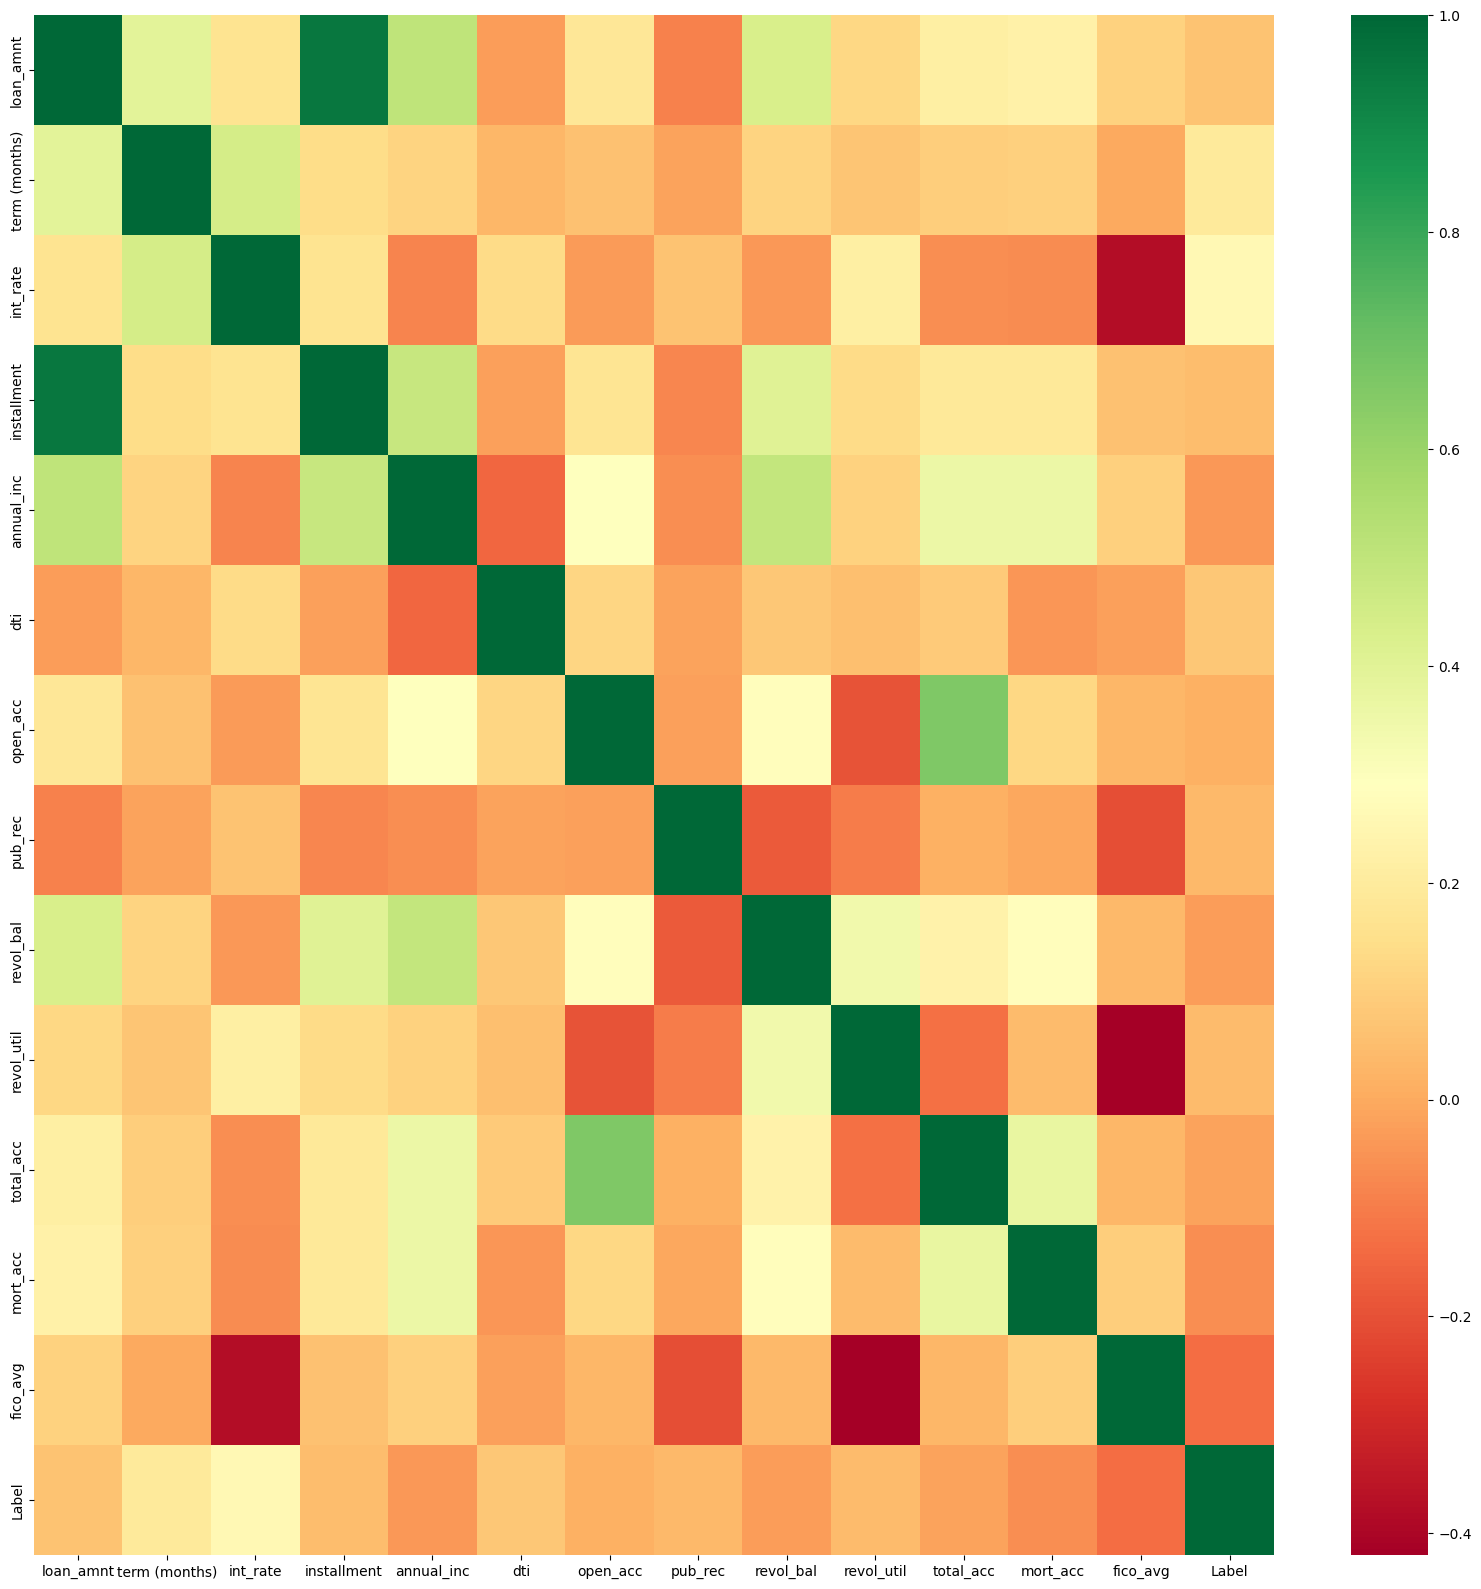

In [30]:
plt.figure(figsize = (20, 20))
sns.heatmap(robust_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

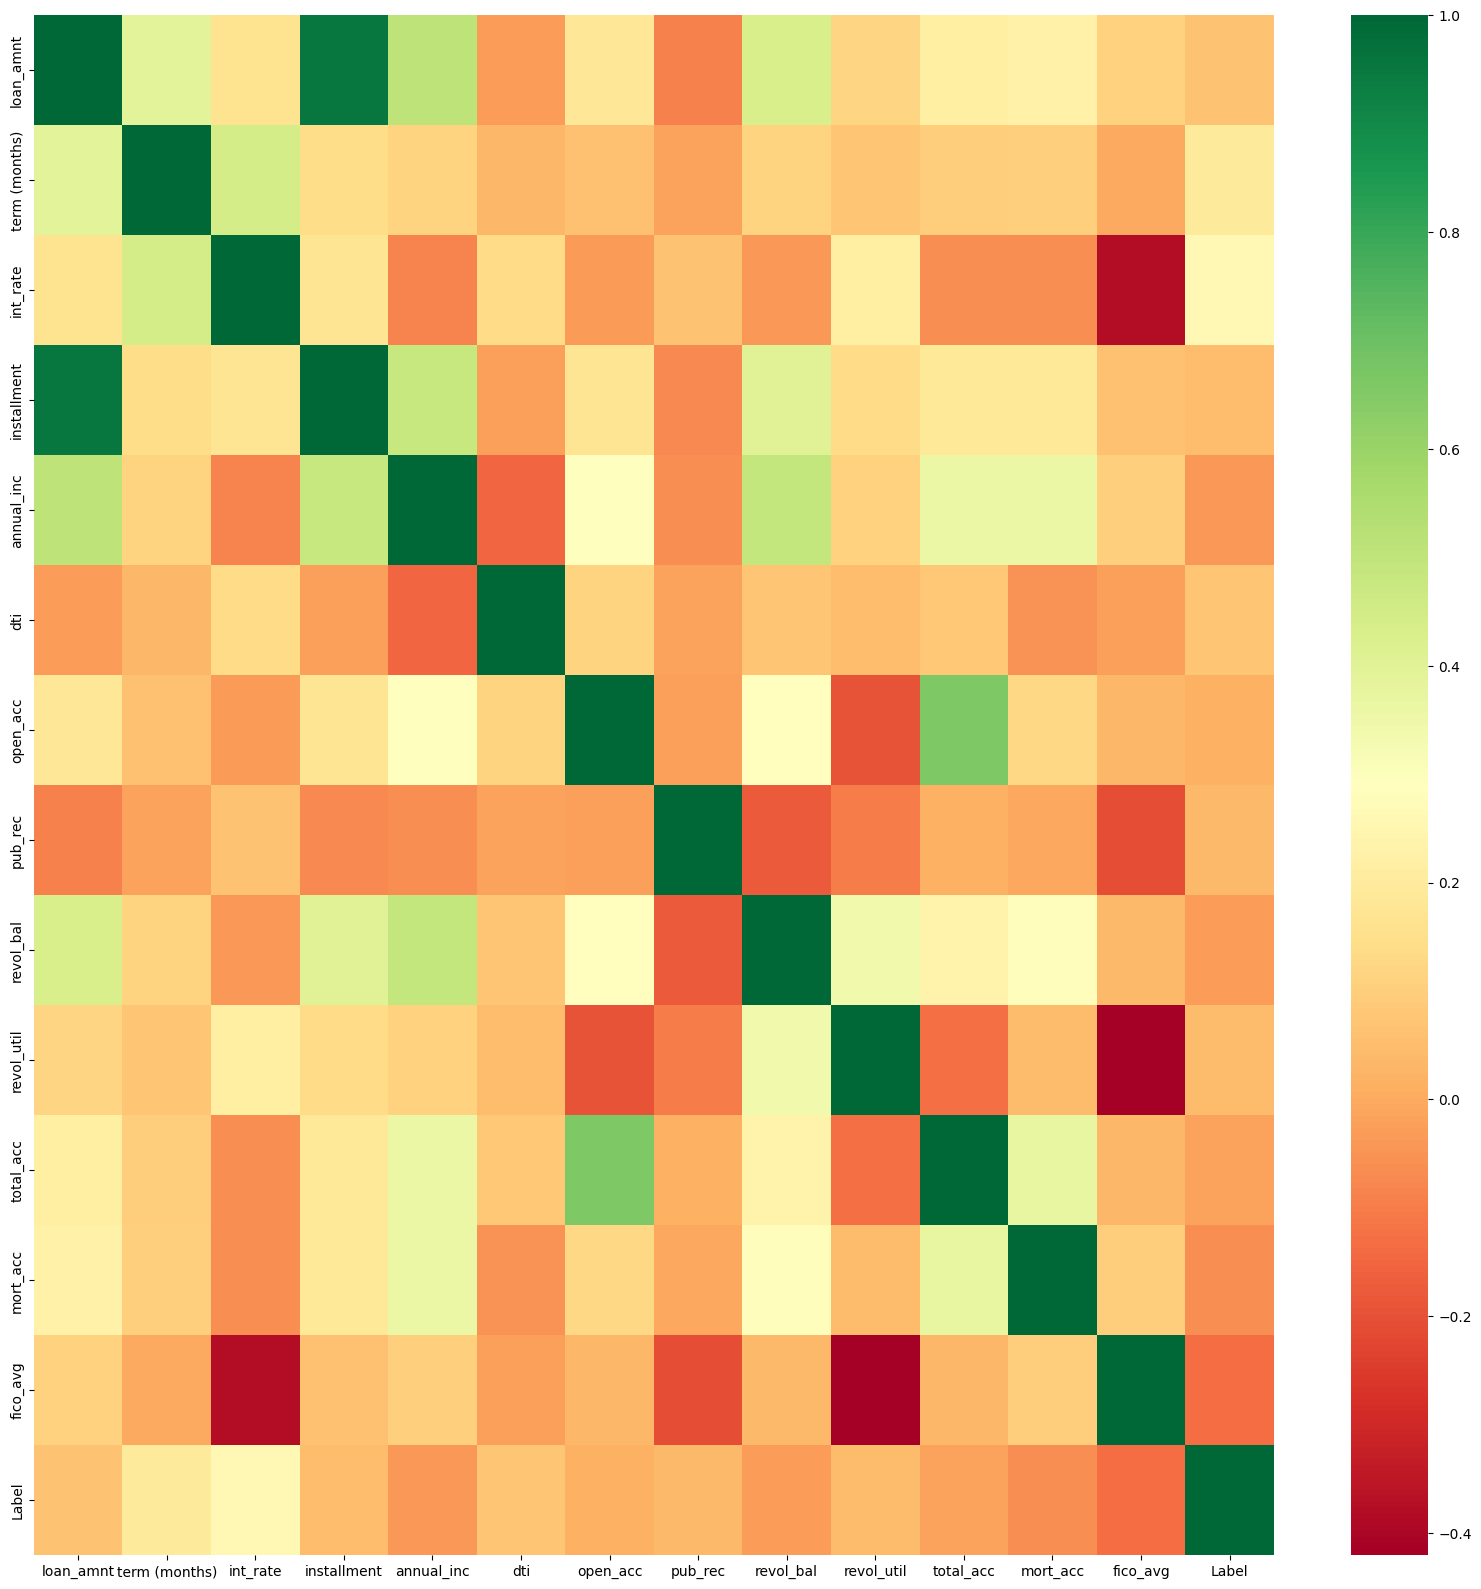

In [31]:
plt.figure(figsize = (20, 20))
sns.heatmap(standard_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

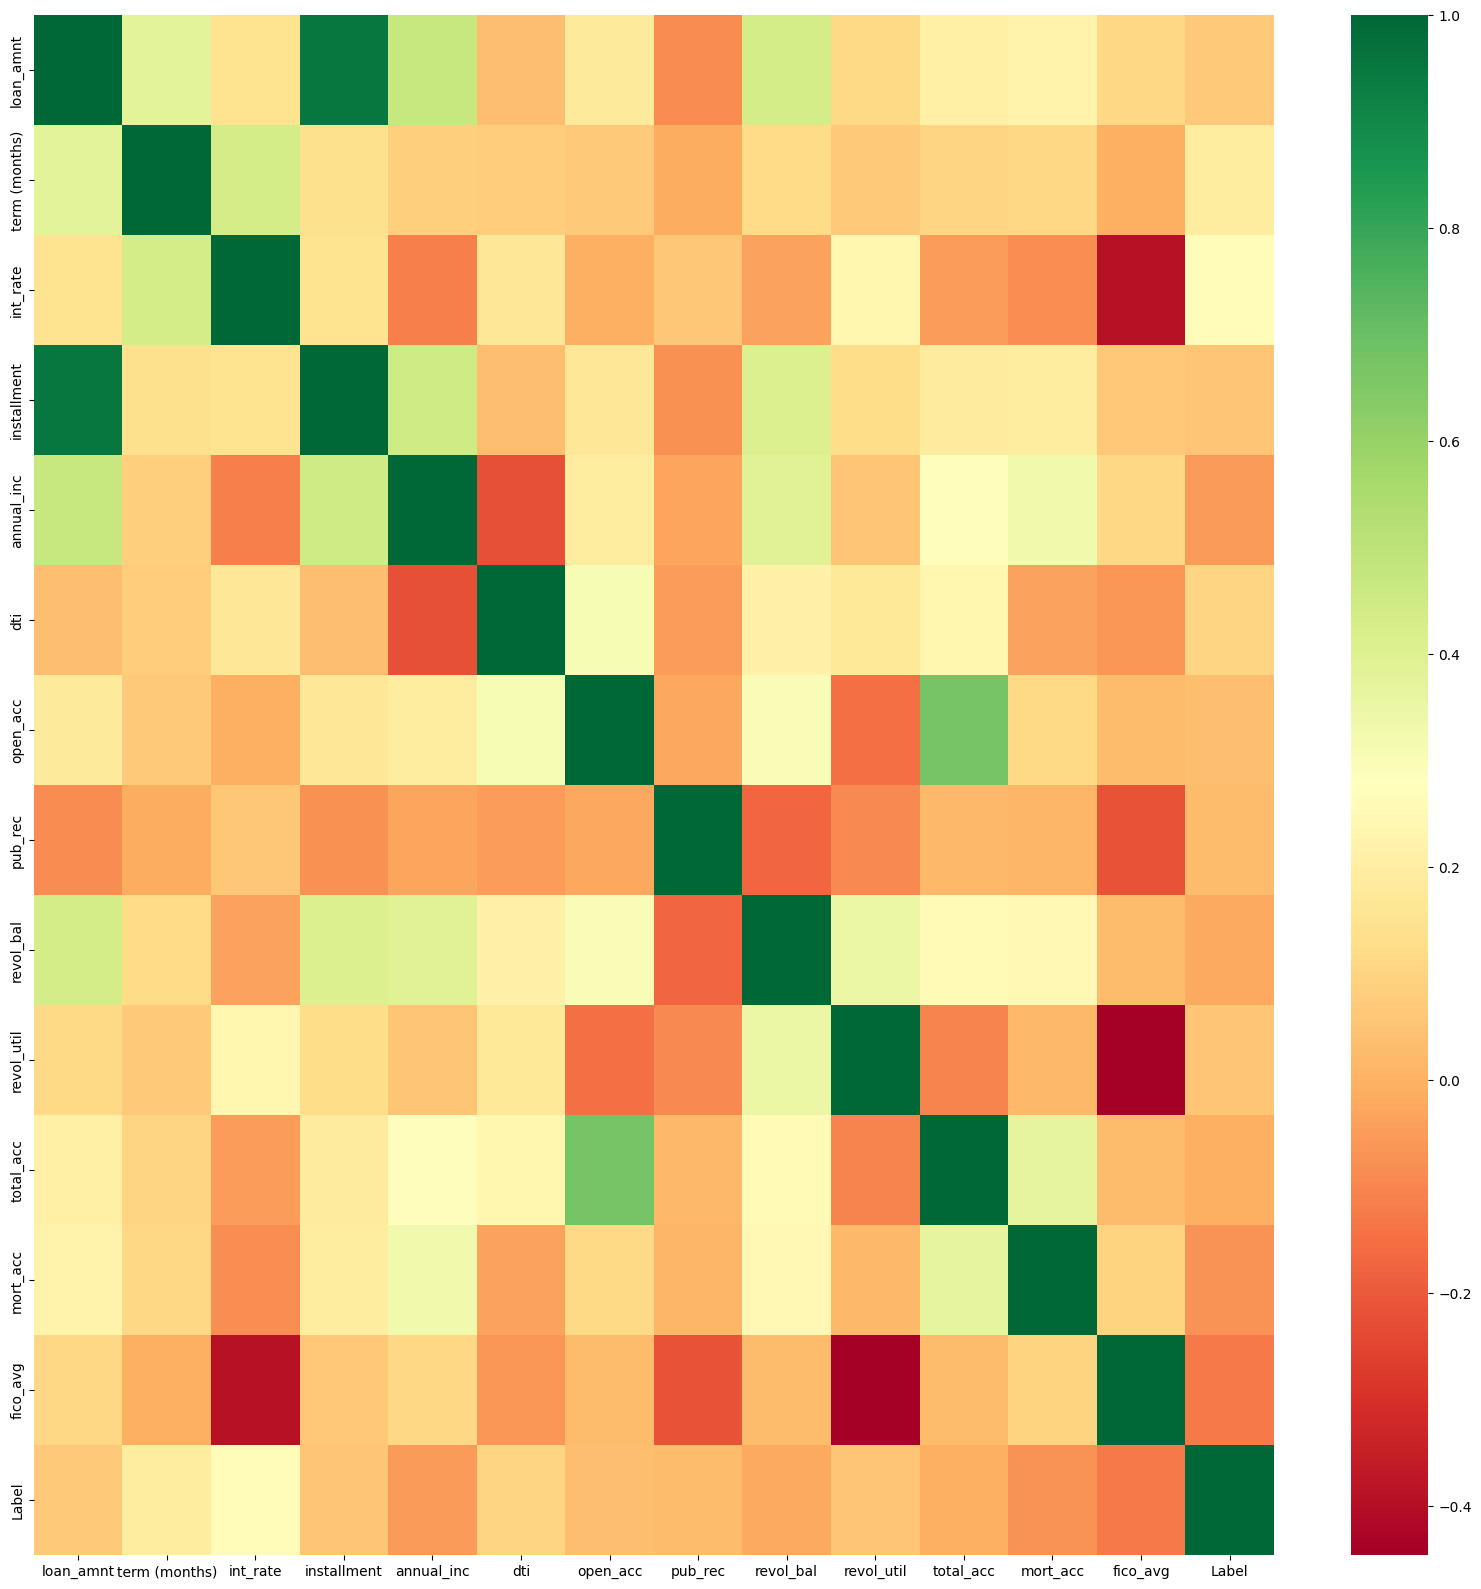

In [32]:
plt.figure(figsize = (20, 20))
sns.heatmap(minmax_train_data[numerical_cols].corr(), cmap="RdYlGn")
plt.show()

In [33]:
X_train_robust  = robust_train_data.drop("Label", axis = 1)
y_train_robust = robust_train_data["Label"]
X_test_robust = robust_test_data.drop("Label", axis = 1)
y_test_robust = robust_test_data["Label"]

X_train_standard = standard_train_data.drop("Label", axis=1)
y_train_standard = standard_train_data["Label"]
X_test_standard = standard_test_data.drop("Label", axis=1)
y_test_standard = standard_test_data["Label"]

X_train_minmax = minmax_train_data.drop("Label", axis=1)
y_train_minmax = minmax_train_data["Label"]
X_test_minmax = minmax_test_data.drop("Label", axis=1)
y_test_minmax = minmax_test_data["Label"]

In [34]:
X_train_robust.shape

(507842, 115)

In [35]:
# from sklearn.preprocessing import PowerTransformer

# # Select only the specified numerical columns
# # selected_numerical_columns = [col for col in numerical_columns if col not in ['Label', 'mort_acc', 'pub_rec']]
# selected_numerical_columns = [col for col in numerical_columns if col not in ['Label']]

# # Apply Box-Cox Transform after handling zero values
# train_data_transformed = X_train[selected_numerical_columns].apply(lambda x: x + 0.000001 if (x <= 0).any() else x)
# pt = PowerTransformer(method='box-cox')
# train_data_transformed[selected_numerical_columns] = pt.fit_transform(train_data_transformed)

# # Replace original numerical columns in X_train with their normalized versions
# X_train[selected_numerical_columns] = train_data_transformed[selected_numerical_columns]


In [36]:
# pd.DataFrame({'cols':selected_numerical_columns,'box_cox_lambdas':pt.lambdas_})

In [37]:
# X_train.columns[X_train.isna().any()].tolist()

In [38]:
# X_test.shape,y_test.shape, X_train.shape, y_train.shape

In [39]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

The SGDClassifier estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the loss hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting loss = 'log'.

In [40]:
naive_model = SGDClassifier(loss='log_loss')


In [41]:
naive_model.fit(X_train_robust, y_train_robust)

SGDClassifier(loss='log_loss')

In [42]:
y_train_pred_robust = naive_model.predict(X_train_robust)
y_pred_robust = naive_model.predict(X_test_robust)

In [43]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 77.05%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.772031       0.621435  0.770482       0.696733   
recall          0.994928       0.027557  0.770482       0.511243   
f1-score        0.869421       0.052774  0.770482       0.461097   
support    390014.000000  117828.000000  0.770482  507842.000000   

            weighted avg  
precision       0.737090  
recall          0.770482  
f1-score        0.679945  
support    507842.000000  
_______________________________________________
Confusion Matrix: 
 [[388036   1978]
 [114581   3247]]

Test Result:
Accuracy Score: 80.68%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg  weighted avg
precision       0.810517      0.552304   0.80677       0.681410       0.76023
recall          0.991931      0.041158   0.80677 

In [44]:
naive_model.fit(X_train_standard, y_train_standard)

SGDClassifier(loss='log_loss')

In [45]:
y_train_pred_standard = naive_model.predict(X_train_standard)
y_pred_standard = naive_model.predict(X_test_standard)

In [46]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)


Train Result:
Accuracy Score: 77.11%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.777737       0.572514  0.771053       0.675126   
recall          0.981831       0.079802  0.771053       0.530816   
f1-score        0.867948       0.140078  0.771053       0.504013   
support    374755.000000  114271.000000  0.771053  489026.000000   

            weighted avg  
precision       0.729783  
recall          0.771053  
f1-score        0.697866  
support    489026.000000  
_______________________________________________
Confusion Matrix: 
 [[367946   6809]
 [105152   9119]]

Test Result:
Accuracy Score: 80.56%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.813510      0.506399  0.805582       0.659954       0.753701
recall          0.984175      0.067130  0.80558

In [47]:
naive_model.fit(X_train_minmax, y_train_minmax)

SGDClassifier(loss='log_loss')

In [48]:
y_train_pred_minmax = naive_model.predict(X_train_minmax)
y_pred_minmax = naive_model.predict(X_test_minmax)

In [49]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)


Train Result:
Accuracy Score: 80.58%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.811982       0.556269  0.805821  6.841252e-01  7.616344e-01
recall          0.986690       0.068061  0.805821  5.273754e-01  8.058214e-01
f1-score        0.890851       0.121283  0.805821  5.060667e-01  7.393309e-01
support    815247.000000  199865.000000  0.805821  1.015112e+06  1.015112e+06
_______________________________________________
Confusion Matrix: 
 [[804396  10851]
 [186262  13603]]

Test Result:
Accuracy Score: 80.51%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.816235      0.497975   0.80511       0.657105       0.754254
recall          0.978207      0.089385   0.80511       0.533796       0.805110
f1-score        0.889911      0.151565   0.80511      

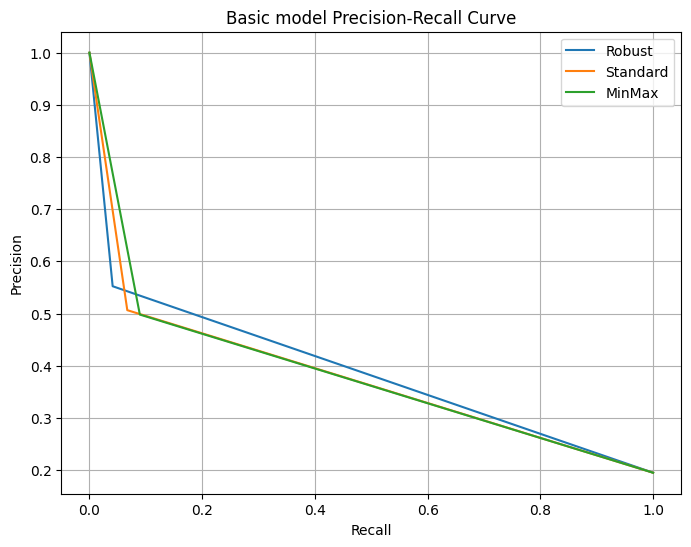

In [50]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_pred_robust, y_pred_standard, y_pred_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Basic model Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [51]:
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced')

kf = StratifiedKFold(n_splits=5, shuffle=False)


In [52]:
param_grid_sgdlogreg = {
    'alpha': [10**-5, 10**-2, 10**1],
    'penalty': ['l1', 'l2']
}

In [53]:
grid_sgdlogreg_robust = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='roc_auc',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

grid_sgdlogreg_standard = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='roc_auc',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)


grid_sgdlogreg_minmax = GridSearchCV(estimator=model, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='roc_auc',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

In [54]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [55]:
grid_sgdlogreg_robust.best_score_

0.7000595791649579

In [56]:
grid_sgdlogreg_robust.best_params_

{'alpha': 0.01, 'penalty': 'l2'}

In [57]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/dhanushlalitha/miniconda3/envs/is5126_project/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [58]:
grid_sgdlogreg_standard.best_score_

0.6999450583495502

In [59]:
grid_sgdlogreg_standard.best_params_

{'alpha': 0.01, 'penalty': 'l2'}

In [60]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SGDClassifier(class_weight='balanced', loss='log_loss',
                                     random_state=1, warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.01, 10], 'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [61]:
grid_sgdlogreg_minmax.best_score_

0.7123205272651415

In [62]:
grid_sgdlogreg_minmax.best_params_

{'alpha': 1e-05, 'penalty': 'l1'}

In [63]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)

In [64]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 65.03%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.855428       0.357008  0.650263       0.606218   
recall          0.655364       0.633381  0.650263       0.644372   
f1-score        0.742149       0.456633  0.650263       0.599391   
support    390014.000000  117828.000000  0.650263  507842.000000   

            weighted avg  
precision       0.739786  
recall          0.650263  
f1-score        0.675904  
support    507842.000000  
_______________________________________________
Confusion Matrix: 
 [[255601 134413]
 [ 43198  74630]]

Test Result:
Accuracy Score: 69.66%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.869400      0.330651  0.696644       0.600026       0.764480
recall          0.733457      0.544430  0.69664

In [65]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)

In [66]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 64.46%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.855496       0.355769  0.644581       0.605632   
recall          0.645187       0.642595  0.644581       0.643891   
f1-score        0.735605       0.457980  0.644581       0.596792   
support    374755.000000  114271.000000  0.644581  489026.000000   

            weighted avg  
precision       0.738724  
recall          0.644581  
f1-score        0.670732  
support    489026.000000  
_______________________________________________
Confusion Matrix: 
 [[241787 132968]
 [ 40841  73430]]

Test Result:
Accuracy Score: 69.32%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.869827      0.328227  0.693238       0.599027       0.764351
recall          0.727996      0.549519  0.69323

In [67]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)

In [68]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

Train Result:
Accuracy Score: 67.83%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.878982       0.328929  0.678254  6.039554e-01  7.706823e-01
recall          0.695073       0.609652  0.678254  6.523621e-01  6.782542e-01
f1-score        0.776284       0.427309  0.678254  6.017963e-01  7.075741e-01
support    815247.000000  199865.000000  0.678254  1.015112e+06  1.015112e+06
_______________________________________________
Confusion Matrix: 
 [[566656 248591]
 [ 78017 121848]]

Test Result:
Accuracy Score: 68.39%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.876555      0.326848  0.683854       0.601702       0.769500
recall          0.706955      0.588335  0.683854       0.647645       0.683854
f1-score        0.782673      0.420236  0.683854      

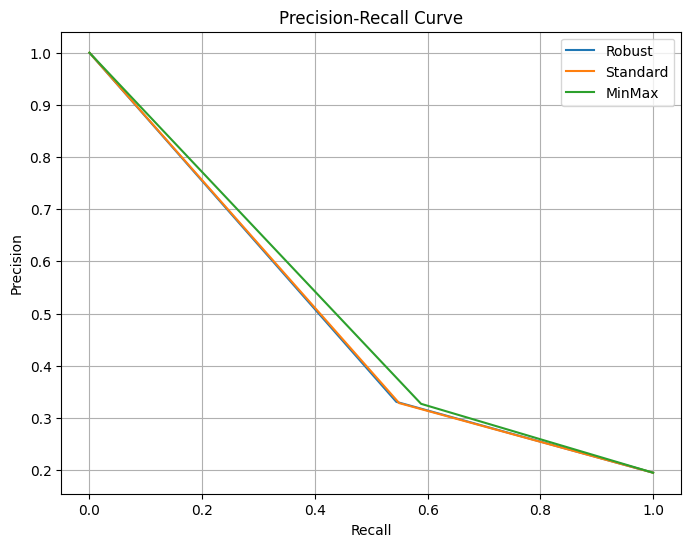

In [69]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_pred_robust, y_pred_standard, y_pred_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


In [70]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

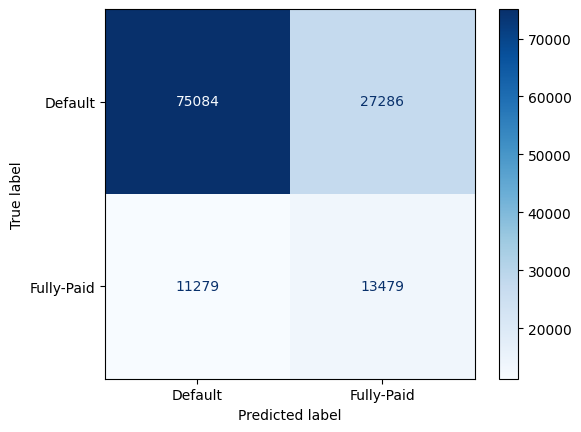

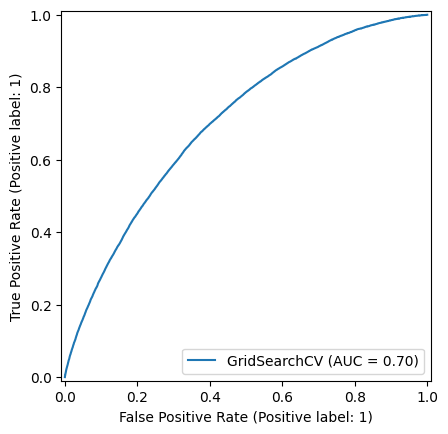

In [71]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

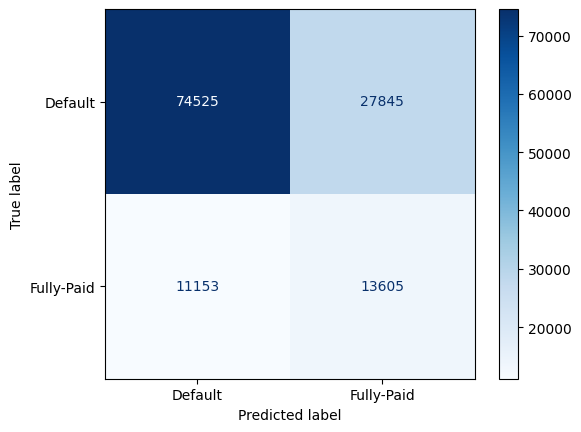

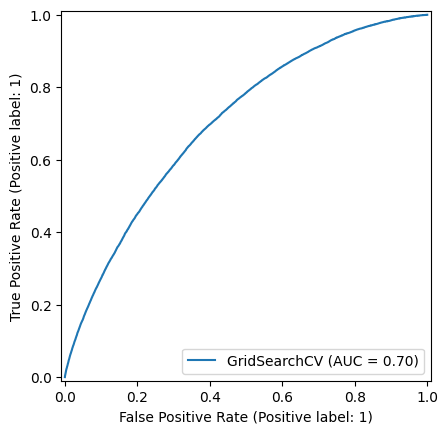

In [72]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

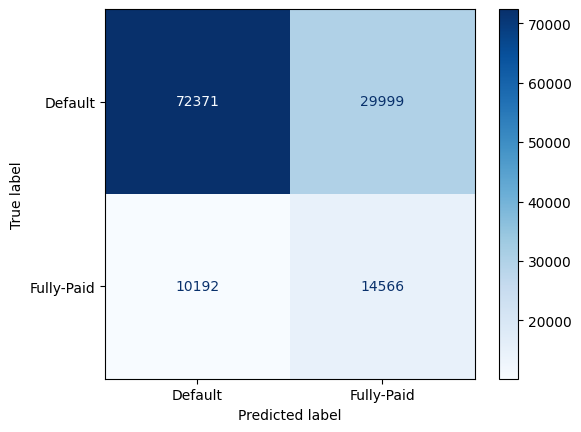

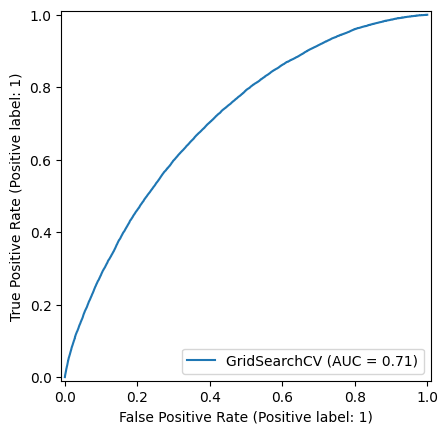

In [73]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)

## With undersampling

In [74]:
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [75]:
rus = RandomUnderSampler(random_state=42)

In [76]:
X_under_robust, y_under_robust = rus.fit_resample(X_train_robust, y_train_robust)
X_under_minmax, y_under_minmax = rus.fit_resample(X_train_minmax, y_train_minmax)
X_under_standard, y_under_standard = rus.fit_resample(X_train_standard, y_train_standard)

In [77]:
print('Fully Paid:', y_under_robust.value_counts()[0], '/', round(y_under_robust.value_counts()[0]/len(y_under_robust) * 100,2), '% of the dataset')
print('Charged Off:', y_under_robust.value_counts()[1], '/',round(y_under_robust.value_counts()[1]/len(y_under_robust) * 100,2), '% of the dataset')




Fully Paid: 117828 / 50.0 % of the dataset
Charged Off: 117828 / 50.0 % of the dataset


In [78]:
param_grid_sgdlogreg = {
    'sgdclassifier__alpha': [0.00001, 0.001, 10],
    'sgdclassifier__penalty': ['l1', 'l2'],
}

In [79]:
pipeline = make_pipeline(RandomUnderSampler(random_state=42),
                       SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=1, warm_start=True, class_weight='balanced'))



In [80]:
grid_sgdlogreg_robust = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='roc_auc',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

grid_sgdlogreg_standard = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='roc_auc',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)


grid_sgdlogreg_minmax = GridSearchCV(estimator=pipeline, 
                               param_grid=param_grid_sgdlogreg, 
                               scoring='roc_auc',  # Change scoring metric to F1 score
                               n_jobs=-1, 
                               pre_dispatch='2*n_jobs', 
                               cv=kf, 
                               verbose=1, 
                               return_train_score=True)

In [81]:
grid_sgdlogreg_robust.fit(X_train_robust, y_train_robust)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [82]:
grid_sgdlogreg_robust.best_score_

0.7012837190144925

In [83]:
grid_sgdlogreg_robust.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [84]:
y_train_pred_robust = grid_sgdlogreg_robust.predict(X_train_robust)
y_pred_robust = grid_sgdlogreg_robust.predict(X_test_robust)

In [85]:
print_score(y_train_robust, y_train_pred_robust, train=True)
print_score(y_test_robust, y_pred_robust, train=False)


Train Result:
Accuracy Score: 63.19%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.862032       0.348057  0.631945       0.605045   
recall          0.619978       0.671555  0.631945       0.645766   
f1-score        0.721238       0.458487  0.631945       0.589862   
support    390014.000000  117828.000000  0.631945  507842.000000   

            weighted avg  
precision       0.742781  
recall          0.631945  
f1-score        0.660275  
support    507842.000000  
_______________________________________________
Confusion Matrix: 
 [[241800 148214]
 [ 38700  79128]]

Test Result:
Accuracy Score: 68.58%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.872796      0.325039  0.685781       0.598918       0.766121
recall          0.713822      0.569836  0.68578

In [86]:
grid_sgdlogreg_standard.fit(X_train_standard, y_train_standard)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [87]:
grid_sgdlogreg_standard.best_score_

0.7003806844531034

In [88]:
grid_sgdlogreg_standard.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [89]:
y_train_pred_standard = grid_sgdlogreg_standard.predict(X_train_standard)
y_pred_standard = grid_sgdlogreg_standard.predict(X_test_standard)

In [90]:
print_score(y_train_standard, y_train_pred_standard, train=True)
print_score(y_test_standard, y_pred_standard, train=False)

Train Result:
Accuracy Score: 63.82%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.858856       0.353179  0.638191       0.606018   
recall          0.631677       0.659555  0.638191       0.645616   
f1-score        0.727954       0.460024  0.638191       0.593989   
support    374755.000000  114271.000000  0.638191  489026.000000   

            weighted avg  
precision       0.740694  
recall          0.638191  
f1-score        0.665346  
support    489026.000000  
_______________________________________________
Confusion Matrix: 
 [[236724 138031]
 [ 38903  75368]]

Test Result:
Accuracy Score: 68.96%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.871355      0.326703  0.689573       0.599029       0.765285
recall          0.720934      0.559900  0.68957

In [91]:
grid_sgdlogreg_minmax.fit(X_train_minmax, y_train_minmax)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('sgdclassifier',
                                        SGDClassifier(class_weight='balanced',
                                                      loss='log_loss',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=-1,
             param_grid={'sgdclassifier__alpha': [1e-05, 0.001, 10],
                         'sgdclassifier__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [92]:
grid_sgdlogreg_minmax.best_score_

0.7132360846487646

In [93]:
grid_sgdlogreg_minmax.best_params_

{'sgdclassifier__alpha': 0.001, 'sgdclassifier__penalty': 'l2'}

In [94]:
y_train_pred_minmax = grid_sgdlogreg_minmax.predict(X_train_minmax)
y_pred_minmax = grid_sgdlogreg_minmax.predict(X_test_minmax)

In [95]:
print_score(y_train_minmax, y_train_pred_minmax, train=True)
print_score(y_test_minmax, y_pred_minmax, train=False)

Train Result:
Accuracy Score: 65.16%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.886429       0.315947   0.65156  6.011879e-01  7.741071e-01
recall          0.649330       0.660656   0.65156  6.549928e-01  6.515596e-01
f1-score        0.749577       0.427466   0.65156  5.885213e-01  6.861566e-01
support    815247.000000  199865.000000   0.65156  1.015112e+06  1.015112e+06
_______________________________________________
Confusion Matrix: 
 [[529364 285883]
 [ 67823 132042]]

Test Result:
Accuracy Score: 64.97%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.886221      0.310799  0.649739       0.598510       0.774158
recall          0.648256      0.655869  0.649739       0.652063       0.649739
f1-score        0.748787      0.421744  0.649739      

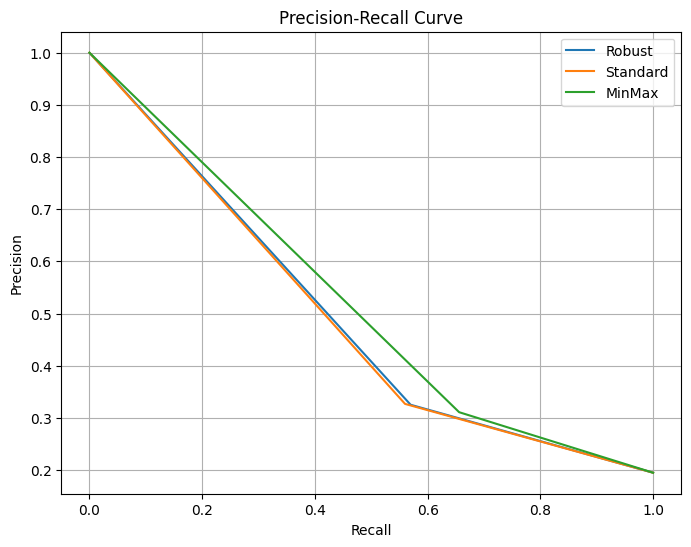

In [96]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_pred_robust, y_pred_standard, y_pred_minmax],[y_test_robust, y_test_standard, y_test_minmax], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


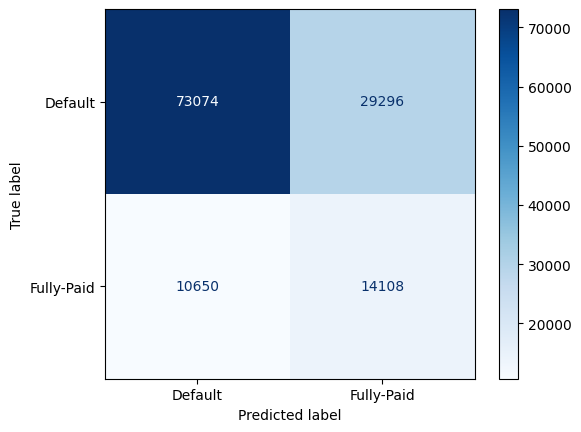

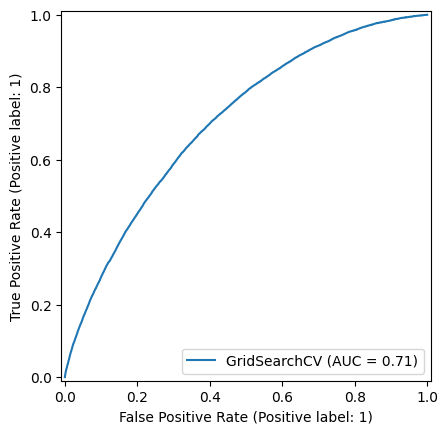

In [97]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_robust, X_test_robust, y_test_robust, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_robust, X_test_robust, y_test_robust)

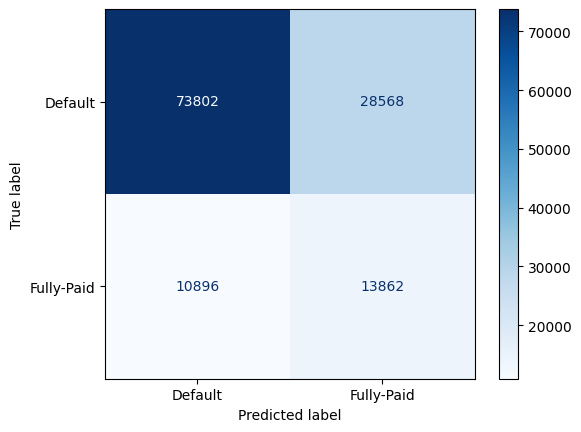

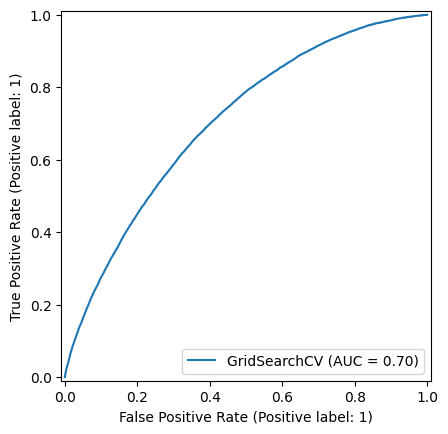

In [98]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_standard, X_test_standard, y_test_standard, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_standard, X_test_standard, y_test_robust)

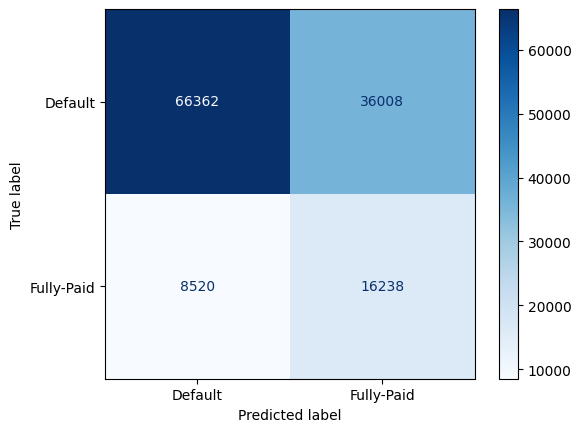

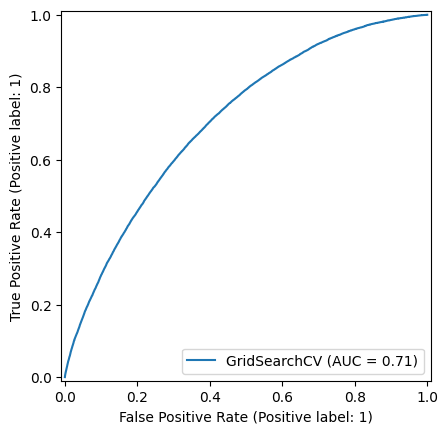

In [99]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(grid_sgdlogreg_minmax, X_test_minmax, y_test_minmax)

# ANN TODO

In [100]:
from tensorflow.keras.metrics import AUC



In [101]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Training Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', 
                  metrics=[
                      AUC(name='AUC', curve='PR')])
    return model

In [102]:
num_columns = X_train_robust.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train_robust, y_train_robust,
    validation_data=(X_test_robust, y_test_robust),
    epochs=20,
    batch_size=32
)

Epoch 1/20


2024-04-04 10:44:06.692212: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15871/15871 [==============================] - 27s 2ms/step - loss: 0.5042 - AUC: 0.3809 - val_loss: 0.4503 - val_AUC: 0.3574
Epoch 2/20
15871/15871 [==============================] - 26s 2ms/step - loss: 0.4983 - AUC: 0.3979 - val_loss: 0.4524 - val_AUC: 0.3616
Epoch 3/20
15871/15871 [==============================] - 26s 2ms/step - loss: 0.4970 - AUC: 0.4014 - val_loss: 0.4489 - val_AUC: 0.3634
Epoch 4/20
15871/15871 [==============================] - 26s 2ms/step - loss: 0.4963 - AUC: 0.4030 - val_loss: 0.4491 - val_AUC: 0.3692
Epoch 5/20
15871/15871 [==============================] - 28s 2ms/step - loss: 0.4955 - AUC: 0.4070 - val_loss: 0.4487 - val_AUC: 0.3672
Epoch 6/20
15871/15871 [==============================] - 27s 2ms/step - loss: 0.4953 - AUC: 0.4084 - val_loss: 0.4493 - val_AUC: 0.3673
Epoch 7/20
15871/15871 [==============================] - 27s 2ms/step - loss: 0.4952 - AUC: 0.4076 - val_loss: 0.4494 - val_AUC: 0.3667
Epoch 8/20
15871/15871 [============================

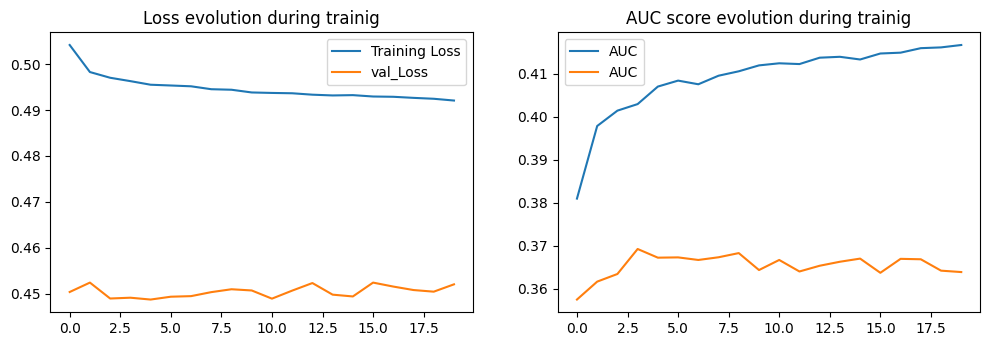

In [103]:
plot_learning_evolution(r)

In [104]:
y_train_pred = model.predict(X_train_robust)
evaluate_nn(y_train_robust, y_train_pred.round(), train=True)

15871/15871 [==============================] - 5s 318us/step
Train Result:
Accuracy Score: 77.57%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy      macro avg  \
precision       0.792918       0.553900  0.775733       0.673409   
recall          0.958237       0.171640  0.775733       0.564939   
f1-score        0.867774       0.262071  0.775733       0.564922   
support    390014.000000  117828.000000  0.775733  507842.000000   

            weighted avg  
precision       0.737462  
recall          0.775733  
f1-score        0.727241  
support    507842.000000  
_______________________________________________
Confusion Matrix: 
 [[373726  16288]
 [ 97604  20224]]

